In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
m = pd.read_csv('dataset/ceb-matrix.csv', index_col='filename').to_numpy()
pg_total = m[:, 0].sum()
optimal_total = np.min(m, axis=1).sum()
print('pg_total:', pg_total)
print('optimal_total:', optimal_total)

pg_p90 = np.percentile(m[:, 0], 90)
optimal_p90 = np.percentile(np.min(m, axis=1), 90)
print('pg_p90:', pg_p90)
print('optimal_p90:', optimal_p90)

pg_total: 10587.665450334549
optimal_total: 3688.4883341789246
pg_p90: 4.558033323287964
optimal_p90: 2.603392314910889


In [3]:
def get_data(filename, new=False):
    total_latency = []
    p50 = []
    p90 = []
    p95 = []
    p99 = []
    execution_time = []
    training_time = []
    inference_time = []
    mse = []
    

    with open(filename) as f:
        results = json.load(f)
        for result in results:
            total_latency.append(result["total_latency"] / 3600)
            p50.append(result["p50"])
            p90.append(result["p90"])
            p95.append(result["p95"])
            p99.append(result["p99"])
            execution_time.append(result["exec_time"] / 3600)
            if "mse" in result:
                mse.append(result["mse"])
            training_time.append(result["training_time"])
            inference_time.append(result["inference_time"])
    
    if new:
        met_new = False
        for i in range(len(execution_time)):
            if not met_new and i > 0 and total_latency[i] > total_latency[i-1]:
                met_new = True
            if met_new:
                execution_time[i] -= pg_total / 3600
            else:
                execution_time[i] -= 7886 / 3600
    else:
        for i in range(len(execution_time)):
            execution_time[i] -= pg_total / 3600
    
    training_time_cdf = np.cumsum(training_time)
    inference_time_cdf = np.cumsum(inference_time)
    
    df = pd.DataFrame({
        "total_latency": total_latency,
        "latency_median": p50,
        "latency_p90": p90,
        "latency_p95": p95,
        "latency_p99": p99,
        "execution_time": execution_time,
        # "execution_time": execution_time + (training_time_cdf + inference_time_cdf) / 3600,
        "training_time": training_time,
        "inference_time": inference_time
    })
    
    if len(mse) > 0:
        df["mse"] = mse
    
    
    return df


In [4]:
def combine_plot(p_mc_lists, mc_lists, n=5000):

    start = -np.inf
    end = np.inf
    for i in range(len(p_mc_lists)):
        p_min = np.min(p_mc_lists[i])
        p_max = np.max(p_mc_lists[i])
        start = max(start, p_min)
        end = min(end, p_max)
    
    x_combined = np.linspace(start, end, n)
    y_combined = np.zeros_like(x_combined)
    fi_list = []
    for i in range(len(p_mc_lists)):
        fi = interp1d(p_mc_lists[i], mc_lists[i], kind='linear')
        y_combined += fi(x_combined)
        fi_list.append(fi(x_combined))

    y_combined = y_combined / len(p_mc_lists)
    std = np.std(fi_list, axis=0)
    
    return x_combined, y_combined, std

def get_multiple(path, x_name, y_name, n=5, npoints=5000, new=False):

    x_list, y_list = [], []
    for i in range(1,n+1):
        df = get_data(path.format(i), new=new)
        x_list.append(df[x_name])
        y_list.append(df[y_name])
    
    x_combined, y_combined, std = combine_plot(x_list, y_list, npoints)
    
    return x_combined, y_combined, std


In [24]:
linewidth=3
markersize=10
gridwidth=1.5
bwith=2
ticks_fontsize=18
label_fontsize=30
title_fontsize=30
fontweight='normal'
markeredgecolor = 'k'
color_scheme = [
    "#4995c6",  # 蓝色
    "#d47628",  # 黄色
    "#8fb943",  # 绿色
    "#d15c6b",  # 红色
    "#8481ba",  # 紫色
    "#413123",  # 棕色
    "#f7a128",  # 橙色
    "#a5a5a5",  # 灰色
]

line_styles = ['-', '--', '-.', ':']

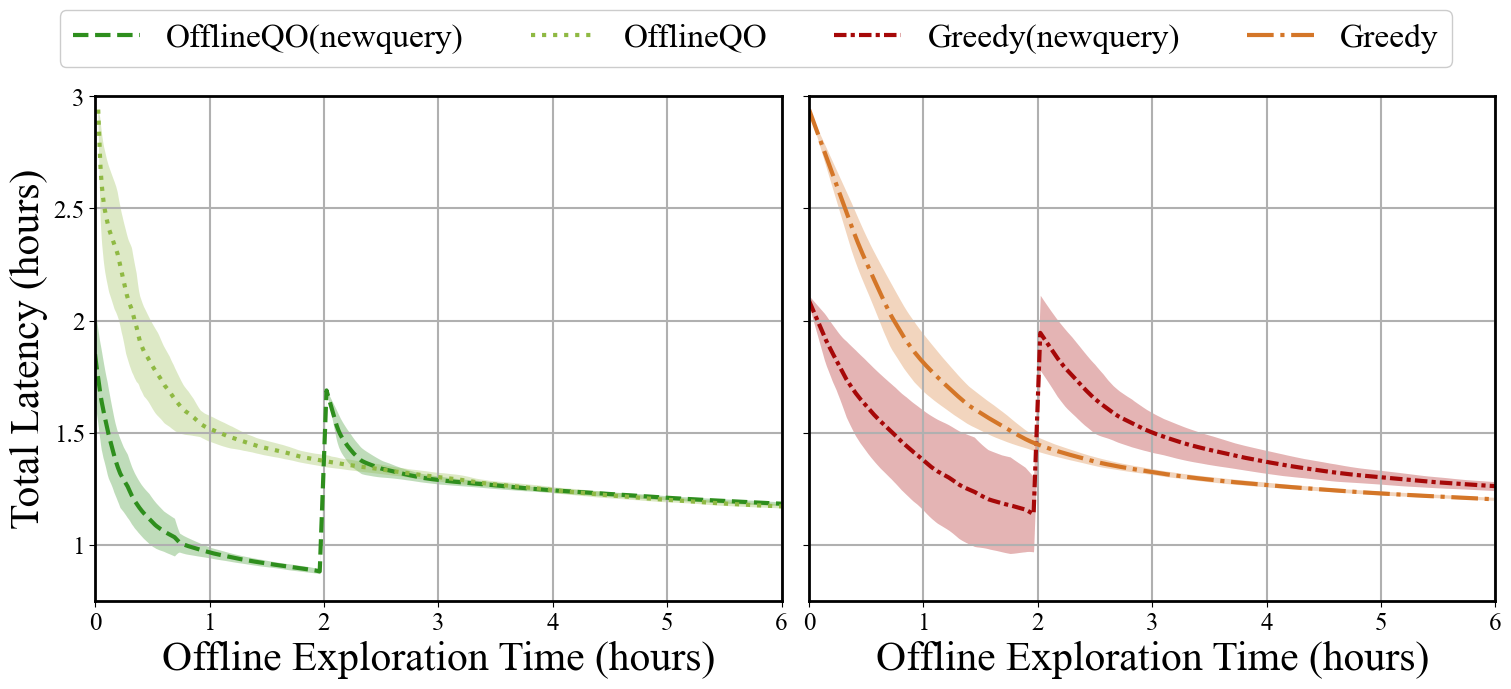

In [25]:

fig, axs = plt.subplots(1,2, figsize=(15, 6), sharey=True, sharex=True, constrained_layout=True)

# set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

ax = axs[0]
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

color_scheme[3] = '#2E8E1D'

x, y, std = get_multiple("experiment/ceb/newquery/als_newquery_timeout_rank5_lambda0.2_alpha1_beta15_run{}.json", "execution_time", "total_latency", n=20, new=True)
ax.plot(x, y, color = color_scheme[3], label='OfflineQO(newquery)', linestyle=line_styles[1],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[3], linewidth=0)

x, y, std = get_multiple("experiment/ceb/limeqo/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[2], label='OfflineQO', linestyle=line_styles[3],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[2], linewidth=0)

ax.grid('--')
ax.set_xlim(-0, 6)
ax.set_ylim(0.75, 3)
ax.set_ylabel('Total Latency (hours)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)

ax = axs[1]

ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

color_scheme[0] = '#a60808'


x, y, std = get_multiple("experiment/ceb/newquery/greedy_newquery_timeout_run{}.json", "execution_time", "total_latency", n=20, new=True)
ax.plot(x, y, color = color_scheme[0], label='Greedy(newquery)', linestyle=(0, (3, 1, 1, 1)),  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[0], linewidth=0)

x, y, std = get_multiple("experiment/ceb/greedy/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[1], label='Greedy', linestyle=line_styles[2],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[1], linewidth=0)

# ax.axhline(pg_total/3600, color = color_scheme[5], linestyle=line_styles[1], linewidth=linewidth) # PG
# ax.axhline(optimal_total/3600, color = color_scheme[4], linestyle=line_styles[1], linewidth=linewidth) # Optimal

fig.legend(framealpha=1,fontsize=24, loc='upper center',ncol=4, bbox_to_anchor=(0.5, 1.15))
ax.grid('--')
# ax.set_yscale('log')
ax.set_yticks([1, 1.5, 2, 2.5, 3],[1, 1.5, 2, 2.5, 3])
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)


plt.savefig('fig/newquery.pdf', bbox_inches='tight')